In [69]:
import tensorflow.keras as keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D
from keras.layers.advanced_activations import ELU
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
import os
import cv2
from os import listdir
from os.path import isfile, join 
import re
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from keras.utils.vis_utils import plot_model
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
num_classes = 4
img_rows, img_cols = 224, 224
batch_size = 16

In [3]:
train_data_dir = "brain_tumor/Training"
validation_data_dir = "brain_tumor/Testing"

Question 1: Read in and visualize an image from each category 

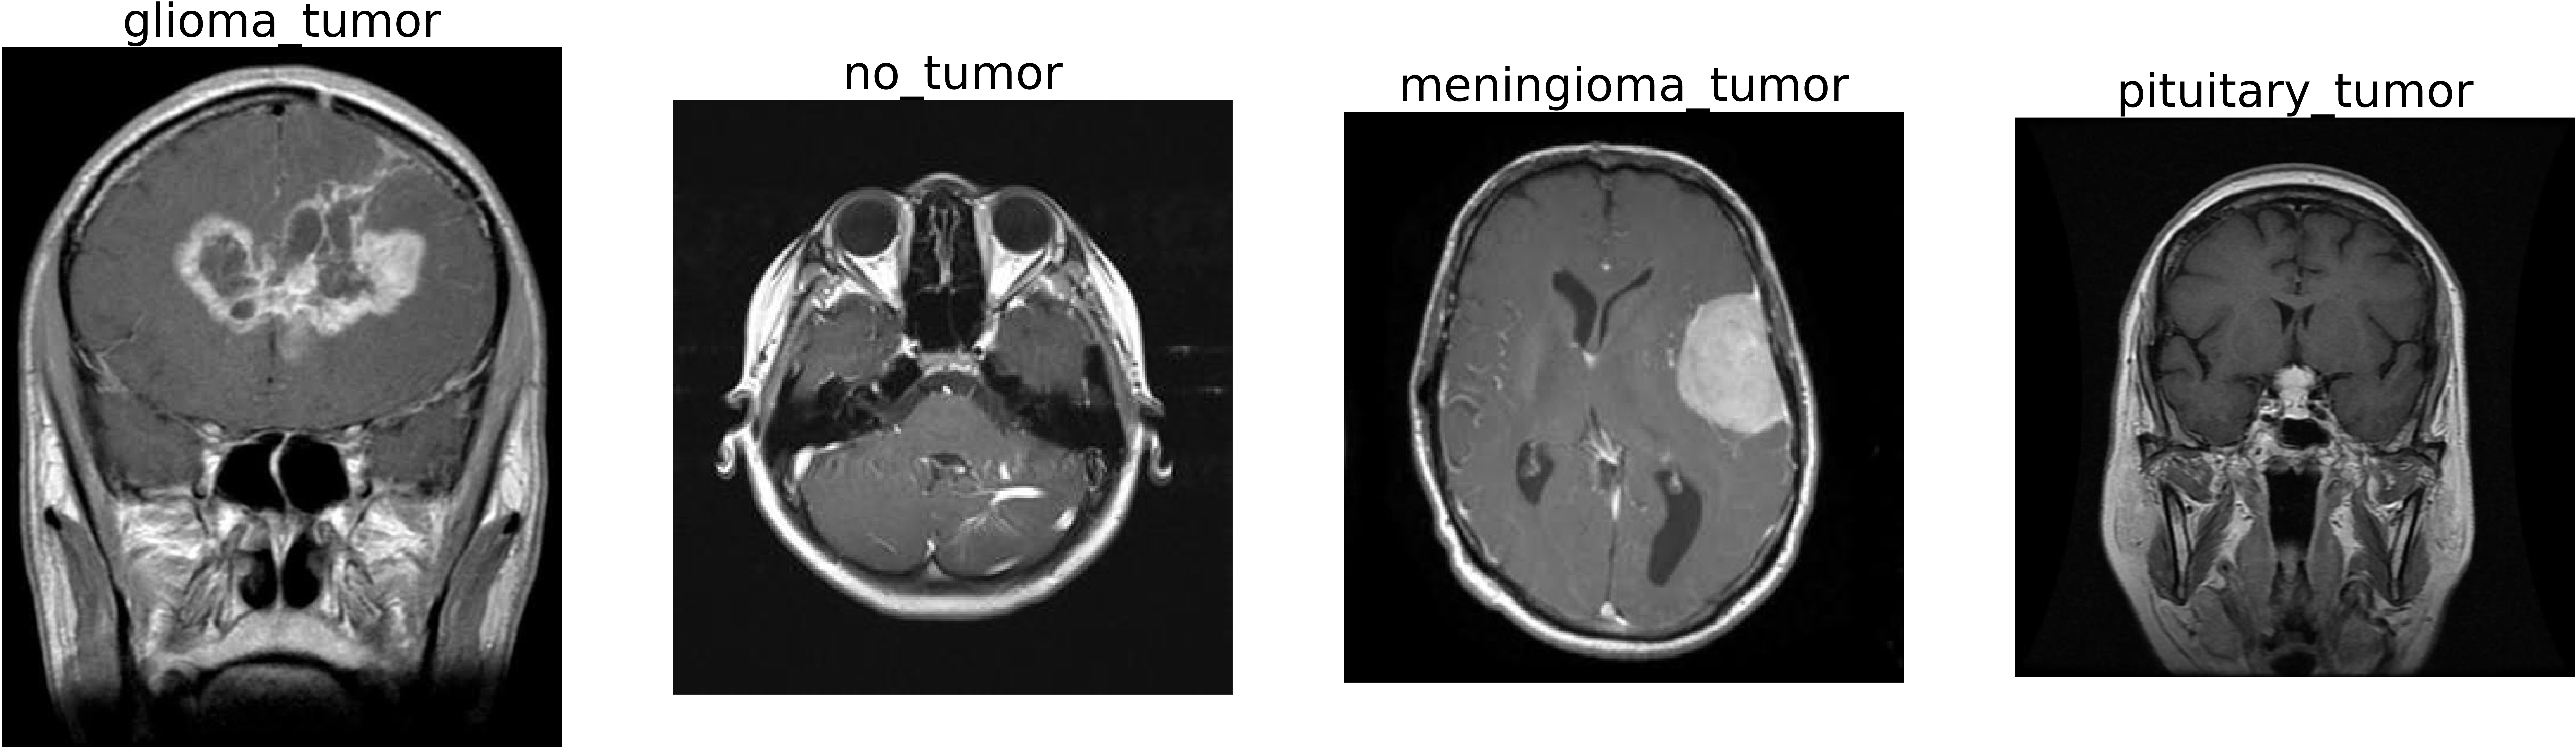

In [50]:
glioma_tumor_pic = mpimg.imread(validation_data_dir+"/glioma_tumor/image.jpg")
no_tumor_pic = mpimg.imread(validation_data_dir+"/no_tumor/image.jpg")
meningioma_tumor_pic = mpimg.imread(validation_data_dir+"/meningioma_tumor/image.jpg")
pituitary_tumor_pic = mpimg.imread(validation_data_dir+"/pituitary_tumor/image.jpg")
plt.figure(figsize=(224, 224))
#plot 1:
plt.subplot(1, 4, 1)
plt.imshow(glioma_tumor_pic)
plt.xticks([])
plt.yticks([])
plt.title("glioma_tumor", fontsize=224)

#plot 2:
plt.subplot(1, 4, 2)
plt.imshow(no_tumor_pic)
plt.xticks([])
plt.yticks([])
plt.title("no_tumor", fontsize=224)

#plot 3:
plt.subplot(1, 4, 3)
plt.imshow(meningioma_tumor_pic)
plt.xticks([])
plt.yticks([])
plt.title("meningioma_tumor",fontsize=224)

#plot 4:
plt.subplot(1, 4, 4)
plt.imshow(pituitary_tumor_pic)
plt.xticks([])
plt.yticks([])
plt.title("pituitary_tumor", fontsize=224)
plt.show()

Question 2: Complete the preprocessing/augmentation process 

In [62]:
# Question 2
# Try different augmentation operation: Rotate, flip, shift, etc.
train_datagen = ImageDataGenerator(
    ## Fill the following lines
    rotation_range=30, 
    width_shift_range=0.5,
    height_shift_range=0.5, 
    brightness_range=None, 
    shear_range=0.5, 
    zoom_range=0.5,
    channel_shift_range=0.5, 
    cval=0.0,
    horizontal_flip=True, 
    vertical_flip=True,
    rescale=None,
    fill_mode="nearest"
)

In [65]:
validation_datagen = ImageDataGenerator(rescale=1./255)

In [63]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode="categorical"
)

Found 2870 images belonging to 4 classes.


In [66]:
validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode="categorical"
)

Found 394 images belonging to 4 classes.


In [125]:
# Question 3
# The convolutional kernal size are all set to be (3, 3), 
# stride is (1, 1), padding is "same". 
# Set other parameters as reasonable numbers.
def cnn():
    model = tf.keras.models.Sequential([

    # 1st CONV-ReLU Layer
    tf.keras.layers.Conv2D(filters = 64,kernel_size=(3,3),strides=(1, 1),padding='same',activation='ReLU',input_shape=(224,224,3)),
    tf.keras.layers.BatchNormalization(),
        
    # 2nd CONV-ReLU Layer
    tf.keras.layers.Conv2D(filters = 64,kernel_size=(3,3),strides=(1, 1),padding='same',activation='ReLU',input_shape=(224,224,3)),
    tf.keras.layers.BatchNormalization(),
        
    # Max Pooling with Dropout 
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2,2), padding='same'),
    tf.keras.layers.Dropout(0.2),
        
    # 3rd set of CONV-ReLU Layers
    tf.keras.layers.Conv2D(filters = 128,kernel_size=(3,3),strides=(1, 1),padding='same',activation='ReLU',input_shape=(224,224,3)),
    tf.keras.layers.BatchNormalization(),
        
    # 4th Set of CONV-ReLU Layers
    tf.keras.layers.Conv2D(filters = 128,kernel_size=(3,3),strides=(1, 1),padding='same',activation='ReLU',input_shape=(224,224,3)),
    tf.keras.layers.BatchNormalization(),
        
    # Max Pooling with Dropout 
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2,2), padding='same'),
    tf.keras.layers.Dropout(0.2),

    # 5th Set of CONV-ReLU Layers
    tf.keras.layers.Conv2D(filters = 256,kernel_size=(3,3),strides=(1, 1),padding='same',activation='ReLU',input_shape=(224,224,3)),
    tf.keras.layers.BatchNormalization(),
        
    # Global Average Pooling
    tf.keras.layers.GlobalAveragePooling2D(),

    # Final Dense Layer
    tf.keras.layers.Dense(4)
    ])
    return model

In [126]:
# Check if you got a similar model summary
model = cnn()
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_68 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 batch_normalization_54 (Bat  (None, 224, 224, 64)     256       
 chNormalization)                                                
                                                                 
 conv2d_69 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 batch_normalization_55 (Bat  (None, 224, 224, 64)     256       
 chNormalization)                                                
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                     

In [127]:
checkpoint_path = "train_ckpt/cp-{epoch:04d}.ckpt"

In [128]:
checkpoint  = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    verbose=1
)

earlystop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=3,
    verbose=1,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', 
    factor=0.3, 
    patience=2,
    min_delta=0.001,
    mode='auto',verbose=1)

callbacks=[checkpoint]

In [129]:
# Compile the model
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [130]:
nb_train_samples = 2870
nb_validation_samples = 394
epochs = 20

In [131]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

Epoch 1/20


<ipython-input-131-18e1c8d31b1f>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


179/179 [==============================] - ETA: 0s - loss: 2.8709 - accuracy: 0.2144
Epoch 1: val_loss improved from inf to 1.44682, saving model to train_ckpt/cp-0001.ckpt


INFO:tensorflow:Assets written to: train_ckpt/cp-0001.ckpt/assets


INFO:tensorflow:Assets written to: train_ckpt/cp-0001.ckpt/assets


179/179 [==============================] - 70s 368ms/step - loss: 2.8709 - accuracy: 0.2144 - val_loss: 1.4468 - val_accuracy: 0.1901
Epoch 2/20
179/179 [==============================] - ETA: 0s - loss: 1.9098 - accuracy: 0.2414
Epoch 2: val_loss did not improve from 1.44682
179/179 [==============================] - 63s 352ms/step - loss: 1.9098 - accuracy: 0.2414 - val_loss: 1.4734 - val_accuracy: 0.2500
Epoch 3/20
179/179 [==============================] - ETA: 0s - loss: 1.7837 - accuracy: 0.1948
Epoch 3: val_loss did not improve from 1.44682
179/179 [==============================] - 63s 350ms/step - loss: 1.7837 - accuracy: 0.1948 - val_loss: 1.5651 - val_accuracy: 0.2656
Epoch 4/20
179/179 [==============================] - ETA: 0s - loss: 1.5683 - accuracy: 0.2197
Epoch 4: val_loss did not improve from 1.44682
179/179 [==============================] - 63s 351ms/step - loss: 1.5683 - accuracy: 0.2197 - val_loss: 1.9884 - val_accuracy: 0.2812
Epoch 5/20
179/179 [===============

INFO:tensorflow:Assets written to: train_ckpt/cp-0009.ckpt/assets


INFO:tensorflow:Assets written to: train_ckpt/cp-0009.ckpt/assets


179/179 [==============================] - 65s 362ms/step - loss: 1.5061 - accuracy: 0.2256 - val_loss: 1.4461 - val_accuracy: 0.2682
Epoch 10/20
179/179 [==============================] - ETA: 0s - loss: 1.4897 - accuracy: 0.2302
Epoch 10: val_loss did not improve from 1.44610
179/179 [==============================] - 63s 352ms/step - loss: 1.4897 - accuracy: 0.2302 - val_loss: 2.6086 - val_accuracy: 0.3177
Epoch 11/20
179/179 [==============================] - ETA: 0s - loss: 1.5152 - accuracy: 0.2302
Epoch 11: val_loss did not improve from 1.44610
179/179 [==============================] - 63s 354ms/step - loss: 1.5152 - accuracy: 0.2302 - val_loss: 1.4722 - val_accuracy: 0.2708
Epoch 12/20
179/179 [==============================] - ETA: 0s - loss: 1.6406 - accuracy: 0.2190
Epoch 12: val_loss did not improve from 1.44610
179/179 [==============================] - 64s 354ms/step - loss: 1.6406 - accuracy: 0.2190 - val_loss: 1.4533 - val_accuracy: 0.2682
Epoch 13/20
179/179 [========

INFO:tensorflow:Assets written to: train_ckpt/cp-0013.ckpt/assets


INFO:tensorflow:Assets written to: train_ckpt/cp-0013.ckpt/assets


179/179 [==============================] - 65s 363ms/step - loss: 1.6126 - accuracy: 0.1920 - val_loss: 1.4153 - val_accuracy: 0.2682
Epoch 14/20
179/179 [==============================] - ETA: 0s - loss: 1.9749 - accuracy: 0.1861
Epoch 14: val_loss did not improve from 1.41528
179/179 [==============================] - 63s 354ms/step - loss: 1.9749 - accuracy: 0.1861 - val_loss: 1.4161 - val_accuracy: 0.2630
Epoch 15/20
179/179 [==============================] - ETA: 0s - loss: 1.6805 - accuracy: 0.1699
Epoch 15: val_loss did not improve from 1.41528
179/179 [==============================] - 63s 354ms/step - loss: 1.6805 - accuracy: 0.1699 - val_loss: 1.4336 - val_accuracy: 0.2708
Epoch 16/20
179/179 [==============================] - ETA: 0s - loss: 1.6249 - accuracy: 0.1069
Epoch 16: val_loss did not improve from 1.41528
179/179 [==============================] - 63s 354ms/step - loss: 1.6249 - accuracy: 0.1069 - val_loss: 1.4418 - val_accuracy: 0.2682
Epoch 17/20
179/179 [========

In [132]:
# Save your model
!mkdir -p saved_model
model.save('saved_model/CNN5_model') 

INFO:tensorflow:Assets written to: saved_model/CNN5_model/assets


INFO:tensorflow:Assets written to: saved_model/CNN5_model/assets


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


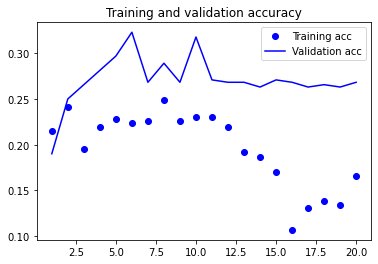

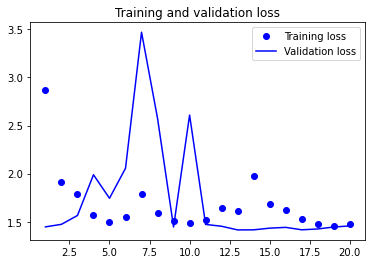

In [150]:
# Question 4
print(history.history.keys())
loss = history.history['loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

#Loss Curves

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

# Accuracy Curves

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [152]:
class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()} 
classes = list(class_labels.values())

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
{0: 'glioma_tumor', 1: 'meningioma_tumor', 2: 'no_tumor', 3: 'pituitary_tumor'}
['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [211]:
y_pred = model.predict_generator(validation_generator, nb_validation_samples//batch_size + 1)
# Question 5
## Fill the line below
y_pred_label = np.argmax(y_pred, axis=1)


<ipython-input-211-412811d3c884>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(validation_generator, nb_validation_samples//batch_size + 1)


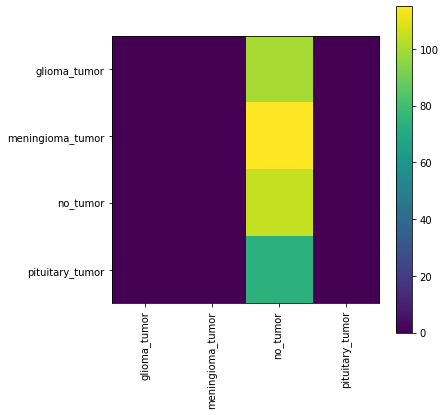

In [212]:
plt.figure(figsize=(6,6))
# Question 5
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred_label)
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

In [213]:
print('Classification Report')
# classification_report(y_true, y_pred, target_names=target_names)
print(classification_report(validation_generator.classes, y_pred_label, target_names=classes))

Classification Report
                  precision    recall  f1-score   support

    glioma_tumor       0.00      0.00      0.00       100
meningioma_tumor       0.00      0.00      0.00       115
        no_tumor       0.27      1.00      0.42       105
 pituitary_tumor       0.00      0.00      0.00        74

        accuracy                           0.27       394
       macro avg       0.07      0.25      0.11       394
    weighted avg       0.07      0.27      0.11       394



/Users/shuang/miniforge3/envs/new_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shuang/miniforge3/envs/new_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shuang/miniforge3/envs/new_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

Question 6
Analyze and expalin the performance of your model (15 points)
How is your training and validation curve? What does this indicate. How can you improve the performance of this model?

Due to the scarcity of traning epoches and images, the curves of training and validation are both unfavorable. The ideal curve of accuracy should have rising trend and loss curve should be a decresing one. However, both of them show 
ups and downs, which is not ideal.

Several approaches can be taken to solving this.
1. Add more training images and increase the training epoches.
2. Add more layers or implement a deeper model by transfer learning.
3. Use cross validation.
4. Add more features.
